<a href="https://colab.research.google.com/github/cergare/data_analysis_fair_workflow/blob/master/segmentation_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Texte alternatif…](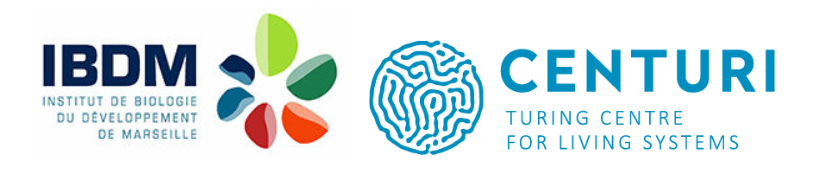
)

<font color = "#008EBF">__Deep Learning @CENTURI "Introduction to biological data analysis" - Fabrice Daian & Leon Espinosa__</font>

# <font color="#D64242">Practical course : </font> __Segmentation from scratch using Keras Framework__

***Goal*** : Create, train and test an image  segmentation model.

***Targeted skills:*** 
- Prepare a segmentation dataset
- Use the _segmentation_models_ library (P. Yakubovskiy) to create your network
- Train a model
- Assess the model quality
- Use your trained model in inference

***Useful links:*** [Keras](https://keras.io/) , [Segmentation_models](https://github.com/qubvel/segmentation_models)




## <font color="#D64242"> Part 1: </font> __MitoEM Dataset__

The dataset available for download on this [page](https://www.epfl.ch/labs/cvlab/software/biomedical/biomedplugins/) consists of a 5x5x5µm section taken from the CA1 hippocampus region of the brain, corresponding to a 1065x2048x1536 volume. The resolution of each voxel is approximately 5x5x5nm. The data is provided as multipage TIF files that can be loaded in Fiji.

The authors annotated mitochondria in two sub-volumes. Each sub-volume consists of the first 165 slices of the 1065x2048x1536 image stack. One subvolume will be use to train the model, and the second one to test it.

![texte du lien](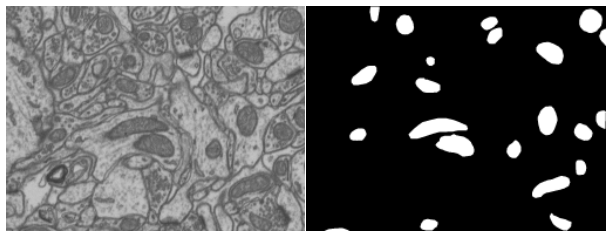
)

### Download the dataset

In [ ]:
!wget -O mitoem.zip https://amubox.univ-amu.fr/s/stNTK5SB2dmQS6T/download
!unzip -qq mitoem.zip
!rm -f mitoem.zip

### Check some image/masks pair using their paths

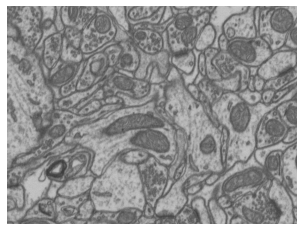

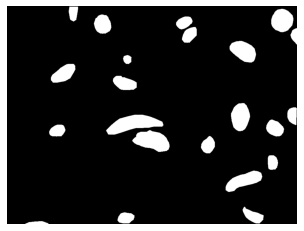

In [2]:
import matplotlib.pyplot as plt
import cv2

A = cv2.imread("./mitoEM/training/images/training0000.tif")
B = cv2.imread("./mitoEM/training/masks/training_groundtruth0000.tif")

plt.imshow(A,cmap="gray")
plt.axis("off")
plt.show()

plt.imshow(B,cmap="gray")
plt.axis("off")
plt.show()


### Read the dataset, convert it to Tensor and work on the pixel range and "data type"

In [3]:
import os
import numpy as np

def read(path,resize=None,type="images"):
  images=[]
  for filename in sorted(os.listdir(path)):
    curimg         = cv2.imread(os.path.join(path,filename))
    if resize is not None:
      curimg = cv2.resize(curimg,dsize=resize,interpolation=cv2.INTER_CUBIC)
    images.append(curimg)
  images=np.array(images)
  if type=="masks":
    images=np.expand_dims(images[:,:,:,0],axis=3)
  return images

Create two variables __X__ and __y__ which will contains respectively the images (sources) and their corresponding masks (targets)

In [4]:
X = read("./mitoEM/training/images/",resize=(512,512),type="images")
y = read("./mitoEM/training/masks/" ,resize=(512,512),type="masks")

Show their Tensor shape:

In [5]:
print("Tensor shape of the training images:", X.shape)
print("Tensor shape of the training masks :", y.shape)

Tensor shape of the training images: (165, 512, 512, 3)
Tensor shape of the training masks : (165, 512, 512, 1)


Display some random image/mask pair:

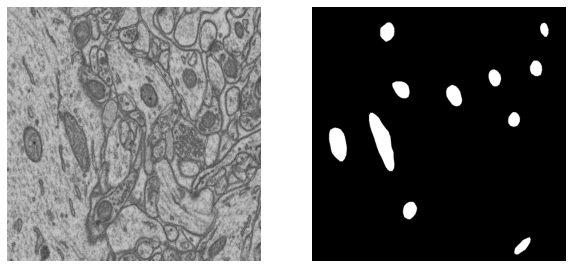

In [6]:
n=np.random.randint(X.shape[0])
fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('One Image/Mask pair')
fig.set_size_inches(10, 5)
ax1.imshow(X[n])
ax1.axis("off")
ax2.imshow(np.squeeze(y[n]),cmap="gray")
ax2.axis("off")
plt.show()



Now we need to work on the pixel intensity range for the images and the masks:

In [7]:
print("Images Min/Max/Data Type: ", np.min(X),"/",np.max(X),"/",X.dtype)
print("Masks  Min/Max/Data Type: ", np.min(y),"/",np.max(y),"/",y.dtype)

Images Min/Max/Data Type:  28 / 236 / uint8
Masks  Min/Max/Data Type:  0 / 255 / uint8


Before finishing the process we need to ensure that: 
- Images are in 8-bit and their pixel intensity ranges from 0 to 255
- Images are of type "uint8"
- Masks pixel intensity ranges from 0 to 1
- Masks are of type "uint8"

Here we convert images and masks in "float32" data type

In [8]:
X = np.float32(X)
y = np.float32(y)

we then modify the masks pixel intensity range so that they fit the [0,1] range

In [9]:
y = y/255

We can check everything is working:

In [10]:
print("Images Min/Max/Data Type: ", np.min(X),"/",np.max(X),"/",X.dtype)
print("Masks  Min/Max/Data Type: ", np.min(y),"/",np.max(y),"/",y.dtype)

Images Min/Max/Data Type:  28.0 / 236.0 / float32
Masks  Min/Max/Data Type:  0.0 / 1.0 / float32


### Split the dataset into Training and Validation set

As we need to monitor the training and avoid under/over fitting, we have to create a validation set.

To do so, we are using the __train_test_split__ function from the popular scikit-learn library

This function needs 4 parameters:
- (1) the images (__X__)
- (2) the masks  (__y__)
- (3) The __ratio__ (between 0 and 1) which correspond to the percentage of images/masks which ne to be allocated into the validation set. For example a ratio of 0.2 means that you want to allocate 20% of the images into the validation set (and 80% into the training set)
- (4) The value of the random generator to be used for the split (for reproductibility)

Moreover, this function will return, in this order, 4 new set containing respectively:
- (1) Training images : by convention we call this array __X_train__
- (2) Validation images : by convention we call this array __X_valid__
- (3) Training masks: by convention we call this array __y_train__
- (4) Validation masks : by convention we call this array __y_valid__

In [11]:
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)

print("Splitting has generated: ")
print("-", X_train.shape[0],"training images/masks")
print("-" ,X_valid.shape[0],"validation images/masks")

Splitting has generated: 
- 132 training images/masks
- 33 validation images/masks


## <font color="#D64242">Part 2 : </font> __Build your Deep Learning Segmentation Model with Keras__

First, we are going to install the __segmentation-models__ library from Pavel Yakubovskiy (https://github.com/qubvel/segmentation_models)

This beautiful library implements 4 types of __segmentation architecture__:
- UNET
- LinkNet
- PSPNet
- FPN

and several different popular __backbones__ pretrained on ImageNet Database (http://www.image-net.org/):

- VGG
- ResNet, SeResnet, ResNeXt and SeResNeXt
- DenseNet
- MobileNet
- EfficientNet
- Inception

In [12]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.1 MB/s eta 0:00:00


UNET networks are by essence Convolutional AutoEncoders and then are made of two parts : 
- Contracting path (Encoder)
- Expansive path (Decoder)

The two paths are symetrically connected to improve the expansive part reconstruction capabilities.

We can create many architecture of Encoder, and the main goal of the __segmentation-models__ library is to provide state of the art backbones architecture pretrained on millions of images using ImageNet Database and make it ready to train in a UNET fashion.


![Texte alternatif…](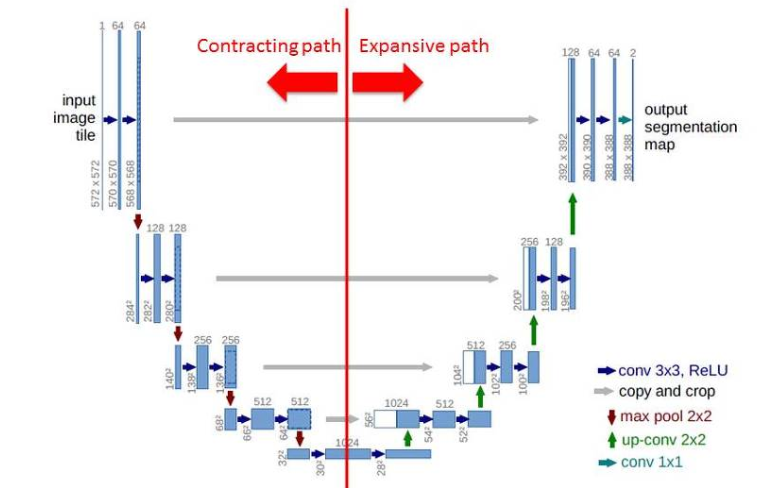
)

Import and configure the library

In [13]:
import tensorflow as tf
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


### Choose one pretrained Backbone

First let's define the __backbone__ we want to use among the complete list you can find into Yakubovskiy Github page [here](https://github.com/qubvel/segmentation_models#models-and-backbones)

One of the best first move you can do is using __Squeeze and Excitation ResNet__ with __18 layers__.

Namely __SeResNet18__ Backbone. ([Original paper](https://arxiv.org/abs/1709.01507))

In [14]:
BACKBONE = "seresnet18"

Let's define the Unet model now. To do so, we are going to use the __segmentation-models__ library.

Coding a UNET model is as easy as:

In [15]:
model = sm.Unet(
        backbone_name   = BACKBONE,
        encoder_weights = "imagenet",
        input_shape     = (512,512,3)
)

45351256/45351256 [==============================] - 1s 0us/step


and that's it !

Let's explain a little bit what's goes on here. We have call the __sm.Unet__ function with 3 parameters:
- __backbone_name__  : the name of the pretrained backbone we want to use
- __encoder_weights__: "imagenet": we want to use a backbone trained on Imagenet and we will use it as the encoder part of our UNET network (Transfer Learning)
- __input_shape__ : the size of our images which will be put into our UNET network

(You can find more information [here](https://segmentation-models.readthedocs.io/en/latest/api.html#unet) on all possible parameters)

## <font color="#D64242">Part 3 : </font> __Model preparation for Training__

### Optimizer, Loss and Metrics

Before going further, we need to choose an optimizer. Among the list of optimizer available with Keras, you can choose the most common one: __Adam__ with a learning rate of __1e-4__

In [16]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4)


Then we need to choose a __loss function__. When you try to address a segmentation problem, you should always consider the __Dice coefficient__

![Texte alternatif…](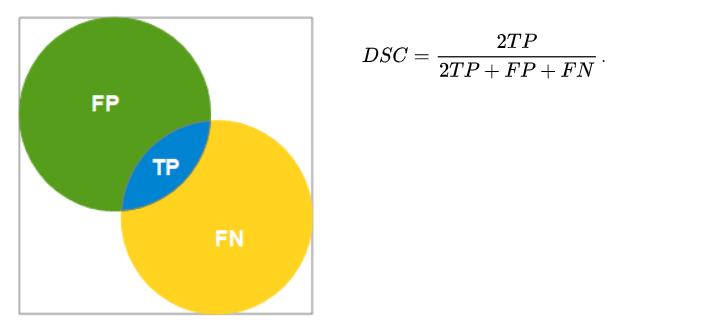
)

Let's using the dice loss from __segmentation-models__ library:

In [17]:
loss = sm.losses.dice_loss

Finally we use a classical segmentation metrics called __IoU__ (Intersection Over Union)

![Texte alternatif…](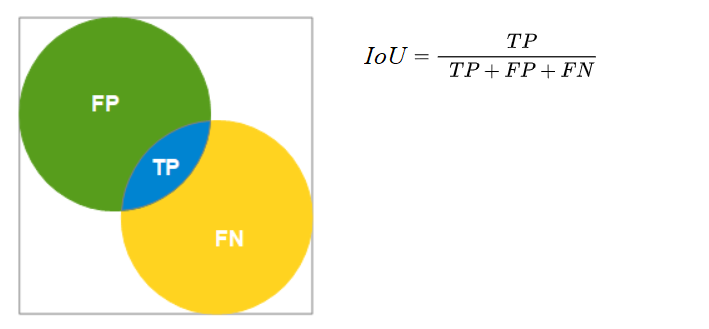
)

Let's using the IoU metrics from __segmentation-models__ library:

In [18]:
metric = sm.metrics.iou_score

Finally, we must compile our model with the optimizer, the loss and the metric:

In [19]:
model.compile(
    optimizer = optimizer,
    loss      = loss,
    metrics   = [metric],
)


## <font color="#D64242">Part 4 : </font> __Training & Model quality check__

Our model is now ready to be trained !

But, before training it we need to operate a last preprocessing step on the data.

As we decided to use a pretrained backbone in our UNET, we need to ensure that the images are preprocesseed the same way as the images which have been used to pretrain the backbone.

To do so, _segmentation model_ libary allows us to fetch every preprocessing function corresponding to every backbone available:

In [20]:
preprocess = sm.get_preprocessing(BACKBONE)

We juste then need to preprocess the images which are in the training set and the validation set:

In [21]:
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)

Now, we are ready to train our model.


To do so, we need to call the Keras function __fit__ to process the training.

We have some parameters to fill in:
- Training set (Training image, Training masks)
- __epochs__: for example 20
- __validation_data__: the validaton images and masks.
- __batch_size__ : the size of the batch used to calculate the gradient at each step. The more is the batch size, the more accurate will be the gradient calculation but the more memory consuming will be the training.


In [22]:
loss_list    = [] #for further display learning curves
val_loss_list= [] #for further display learning curves

In [49]:
H = model.fit(
   X_train,y_train,
   epochs=20,
   validation_data=(X_valid, y_valid),
   batch_size=8
)

loss_list.append(H.history["loss"])          # for display, aggregate history in case of retrain
val_loss_list.append(H.history["val_loss"])  # for display, aggregate history in case of retrain

Epoch 1/20
17/17 [==============================] - 25s 472ms/step - loss: 0.0980 - iou_score: 0.8214 - val_loss: 0.1109 - val_iou_score: 0.8008
Epoch 2/20
17/17 [==============================] - 7s 418ms/step - loss: 0.0931 - iou_score: 0.8311 - val_loss: 0.1067 - val_iou_score: 0.8078
Epoch 3/20
17/17 [==============================] - 7s 407ms/step - loss: 0.0889 - iou_score: 0.8363 - val_loss: 0.1017 - val_iou_score: 0.8157
Epoch 4/20
17/17 [==============================] - 7s 411ms/step - loss: 0.0843 - iou_score: 0.8450 - val_loss: 0.0984 - val_iou_score: 0.8208
Epoch 5/20
17/17 [==============================] - 7s 411ms/step - loss: 0.0805 - iou_score: 0.8517 - val_loss: 0.0954 - val_iou_score: 0.8265
Epoch 6/20
17/17 [==============================] - 7s 427ms/step - loss: 0.0775 - iou_score: 0.8548 - val_loss: 0.0926 - val_iou_score: 0.8303
Epoch 7/20
17/17 [==============================] - 7s 423ms/step - loss: 0.0736 - iou_score: 0.8629 - val_loss: 0.0896 - val_iou_score

Let's plot the training/validation curve of the current model:

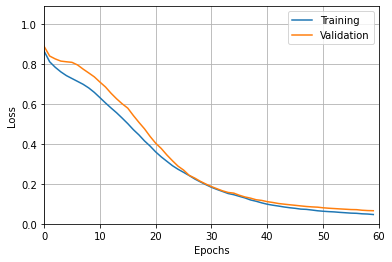

In [50]:
plt.plot(sum(loss_list,[]))
plt.plot(sum(val_loss_list,[]))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training","Validation"])
plt.grid("on")
plt.xlim([0,len(sum(loss_list,[]))])
plt.ylim([0,np.max(sum(loss_list,[])+sum(val_loss_list,[]))+0.2])
plt.show()

At this point, you can also assess the segmentation quality visually.

You can use the _predict_ method on the validation dataset and display the model prediction (segmentation) of some images coming from the validation set.

In [38]:
p = model.predict(X_valid,verbose = 1)

2/2 [==============================] - 1s 425ms/step


and display some random images / Ground truth Masks / Predicted Masks

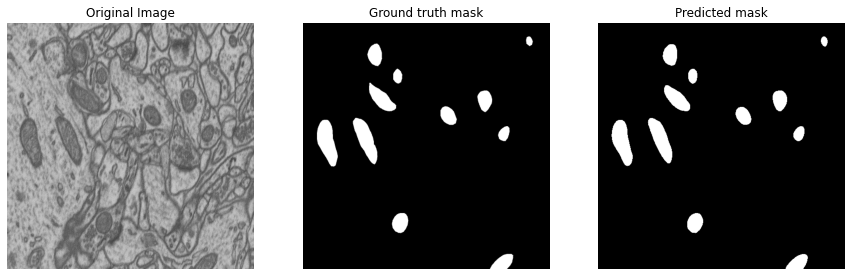

In [39]:
n=np.random.randint(p.shape[0])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 10)
ax1.imshow(np.uint8(X_valid[n]))
ax1.axis("off")
ax1.set_title("Original Image")
ax2.imshow(np.squeeze(np.uint8(y_valid[n]*255)),cmap="gray")
ax2.axis("off")
ax2.set_title("Ground truth mask")
ax3.imshow(np.squeeze(np.uint8((p[n]>0.5)*255)),cmap="gray")
ax3.axis("off")
ax3.set_title("Predicted mask")
plt.show()

Once trained, you can save your model to be further reused:

In [40]:
model.save("segmentation_mito.h5")

## <font color="#D64242">Part 5 : </font> __Reuse a model in inference on new data__

At this point, you have a model trained and you need to use on new data.

To do so, we are going to use it in inference on the images located into the "testing" dataset we have download before.

At this point, the data need to follow exactly the same preprocessing pipeline we used to preprocess the training dataset before feeding it to the model.

### Read and preprocess the new dataset

We can use the read procedure written before:

In [41]:
X_new = read("./mitoEM/testing/images/",resize=(512,512),type="images")

We need to check the tensor shape of this new dataset and be sure that the pixel intensity range is between 0 and 255 (8-bit).

In [42]:
print("Images Min/Max/Data Type: ", np.min(X_new),"/",np.max(X_new),"/",X_new.dtype)

Images Min/Max/Data Type:  14 / 255 / uint8


Now we need to convert it in "float32" data type

In [43]:
X_new = np.float32(X_new)

and finally use the backbone preprocessing function:

In [44]:
X_new = preprocess(X_new)

### Load the trained model

In [45]:
from tensorflow.keras.models import load_model

model = load_model("segmentation_mito.h5",
                   custom_objects={
                       "dice_loss": sm.losses.dice_loss,
                       "iou_score": sm.metrics.iou_score

})

and make the prediction using your model:

In [46]:
pred = model.predict(X_new,verbose=1)

6/6 [==============================] - 3s 403ms/step


you can visualize some prediction on the test dataset :

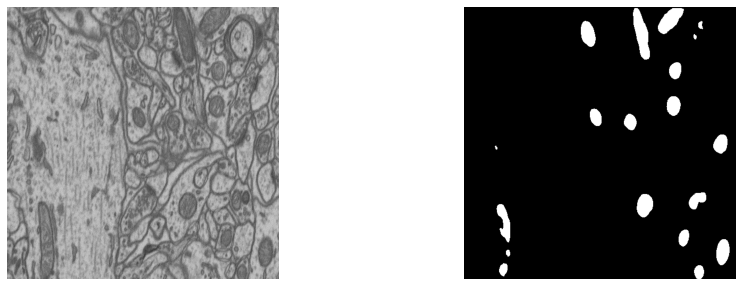

In [47]:
n=np.random.randint(pred.shape[0])
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
ax1.imshow(np.uint8(X_new[n]))
ax1.axis("off")
ax2.imshow(np.squeeze(np.uint8((pred[n]>0.5)*255)),cmap="gray")
ax2.axis("off")
plt.show()

and save your predictions in a file you can visualize, manipulate ... on Fiji eventually.

In [48]:
import tifffile

tifffile.imwrite("my_segmentation.tif", np.squeeze(np.uint8((pred>0.5)*255) ))

## --

<font color="green">__Notebook License__</font>

Fabrice Daian (2023)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.